# 2D Poisson problem

In [2]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.utilities import ExpressionFromCallable
from cuqipy_fenics.testproblem import FEniCSPoisson2D, FEniCSDiffusion1D
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt

Print CUQIpy and CUQIpy-FEniCS versions:

In [3]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)
print(cuqipy_fenics.__file__)

0+untagged.3470.g36baffb
0+untagged.256.g7d0d1eb
/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy-FEniCS/cuqipy_fenics/__init__.py


In [4]:
physical_dim = 1 # choice of physical dimension

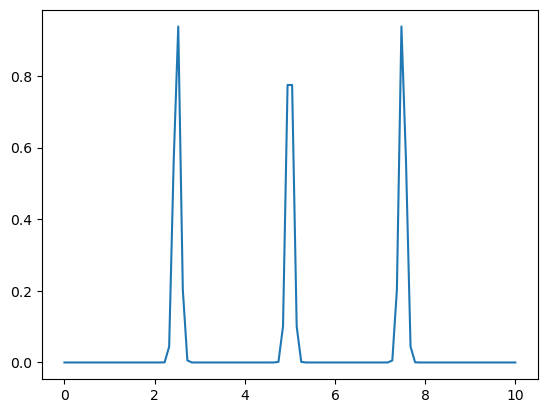

In [5]:
endpoint = 10 # domain length
# f is sum of 3 exponentials at 1/4*endpoint and 1/2*endpoint and 3/4*endpoint

def f(x):
    return np.exp(-100*(x-1/4*endpoint)**2) + np.exp(-100*(x-1/2*endpoint)**2) + np.exp(-100*(x-3/4*endpoint)**2)

#plot f
x = np.linspace(0, endpoint, 100)
plt.plot(x, f(x))


f_expr = ExpressionFromCallable(f)

In [6]:
if physical_dim == 2:
    A = FEniCSPoisson2D(dim=(16,16), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Neumann', 'Dirichlet', 'Neumann']).model
elif physical_dim == 1:

    A = FEniCSDiffusion1D(dim=40, right_bc=0, f=f_expr, endpoint=endpoint).model # note source term is zero for the 1D case

In [7]:
G_domain = A.domain_geometry
G_range = A.range_geometry

In [8]:
A.pde


CUQI SteadyStateLinearFEniCSPDE.
PDE form expression:
        def form(m,u,p):
            return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx -f*p*ufl.dx

In [9]:
# SMPrior class
class SMPrior:
    def __init__(self, ginv, corrlength, var, mean, covariancetype=None):
        self.corrlength = corrlength
        self.mean = mean
        self.c = 1e-9  # default value
        if covariancetype is not None:
            self.covariancetype = covariancetype
        else:
            self.covariancetype = 'Squared Distance'  # default
        self.compute_L(ginv, corrlength, var)

    def compute_L(self, g, corrlength, var):
        ng = g.shape[0]
        a = var - self.c
        b = np.sqrt(-corrlength**2 / (2 * np.log(0.01)))
        Gamma_pr = np.zeros((ng, ng))

        for ii in range(ng):
            for jj in range(ii, ng):
                dist_ij = np.linalg.norm(g[ii, :] - g[jj, :])
                if self.covariancetype == 'Squared Distance':
                    gamma_ij = a * np.exp(-dist_ij**2 / (2 * b**2))
                elif self.covariancetype == 'Ornstein-Uhlenbeck':
                    gamma_ij = a * np.exp(-dist_ij / corrlength)
                else:
                    raise ValueError('Unrecognized prior covariance type')
                if ii == jj:
                    gamma_ij = gamma_ij + self.c
                Gamma_pr[ii, jj] = gamma_ij
                Gamma_pr[jj, ii] = gamma_ij
        
        self.cov = Gamma_pr
        self.L = np.linalg.cholesky(np.linalg.inv(Gamma_pr)).T

    def draw_samples(self, nsamples):
        samples = self.mean + np.linalg.solve(self.L, np.random.randn(self.L.shape[0], nsamples))
        return samples

    def eval_fun(self, args):
        sigma = args[0]
        res = 0.5 * np.linalg.norm(self.L @ (sigma - self.mean))**2
        return res
    
    def evaluate_target_external(self, x, compute_grad=False):
        x = x.reshape((-1,1))
        # print("x.shape: ", x.shape)
        # print("self.mean.shape: ", self.mean.shape)
        if compute_grad:
            grad = self.L.T @ self.L @ (x - self.mean)
        else:
            grad = None
        
        return self.eval_fun(x), grad
        

    def compute_hess_and_grad(self, args, nparam):
        sigma = args[0]
        Hess = self.L.T @ self.L
        grad = Hess @ (sigma - self.mean)

        if nparam > len(sigma):
            Hess = np.block([[Hess, np.zeros((len(sigma), nparam - len(sigma)))],
                             [np.zeros((nparam - len(sigma), len(sigma))), np.zeros((nparam - len(sigma), nparam - len(sigma)))]])
            grad = np.concatenate([grad, np.zeros(nparam - len(sigma))])


        return Hess, grad

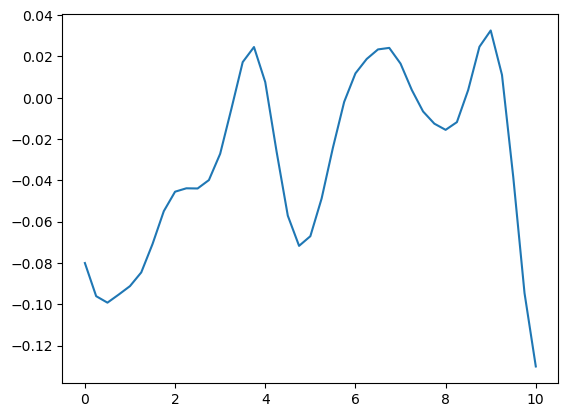

In [10]:

# Create correlation matrix for prior x

H = G_domain.function_space

v2d = dl.vertex_to_dof_map(H)
d2v = dl.dof_to_vertex_map(H)

mesh = G_domain.mesh 


mean_sigma = np.zeros((H.dim(), 1)) #linearization point
corrlength =  0.2 * endpoint
var_sigma = 0.05 ** 2   #prior variance

smprior = SMPrior(mesh.coordinates()[d2v], corrlength, var_sigma, mean_sigma)#, covariancetype='Ornstein-Uhlenbeck')


sample = smprior.draw_samples(1)
fun = dl.Function(H)
fun.vector().set_local(sample)

im = dl.plot(fun)
if physical_dim == 2:
    plt.colorbar(im)






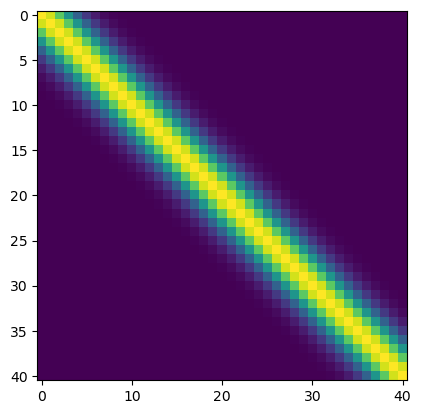

In [11]:
# visualize the covariance matrix 
plt.figure()
plt.imshow(smprior.cov)

In [12]:
x = Gaussian(np.zeros(G_domain.par_dim), cov=100*smprior.cov, geometry=G_domain)

In [13]:
# Set the random seed
np.random.seed(3) 

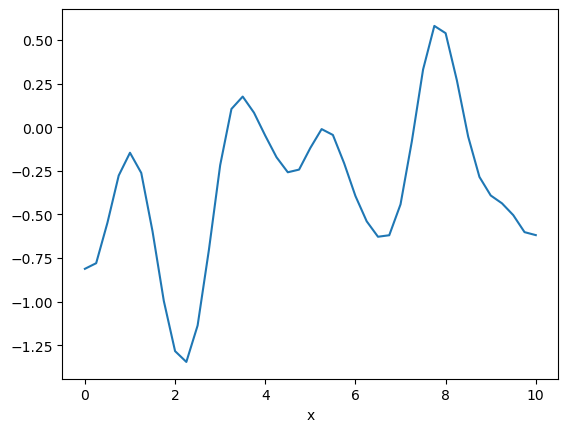

In [14]:
x_true = x.sample()
im = x_true.plot()
if physical_dim == 2:
    plt.colorbar(im[0])



This cell to compute s_noise

In [15]:
noise_level = 0.01
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_domain.par_dim)* noise_level*np.linalg.norm(y_true)

[[<matplotlib.lines.Line2D at 0x1984da4a0>]]

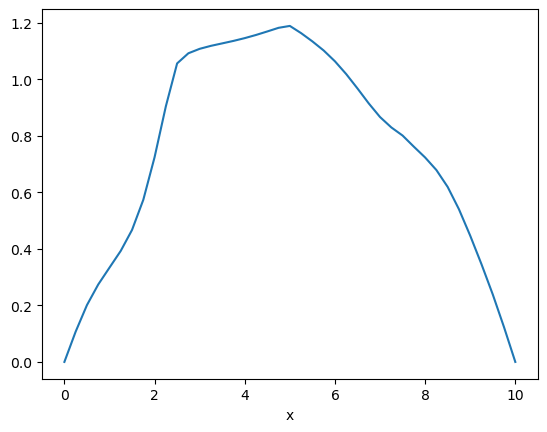

In [16]:
y_true.plot()

In [17]:
y = Gaussian(A(x), s_noise**2, geometry=G_range)

[[<matplotlib.lines.Line2D at 0x198a3a8f0>]]

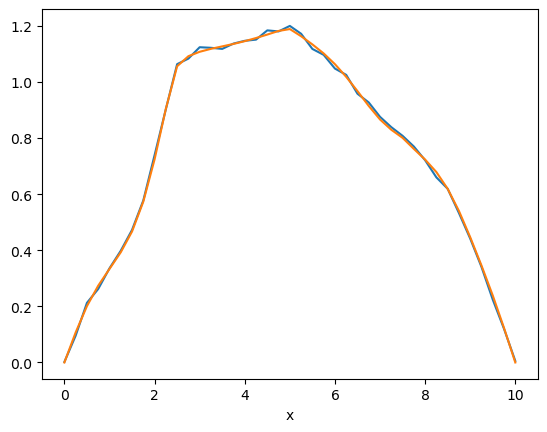

In [18]:
y_obs = y(x=x_true).sample()
y_obs.plot()
y_true.plot()

In [19]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

In [20]:
# map point 
map_x = BP.MAP()


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is a work-in-progress !!!
!!!      Always validate the computed results.       !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


(-1.5, 0.7)

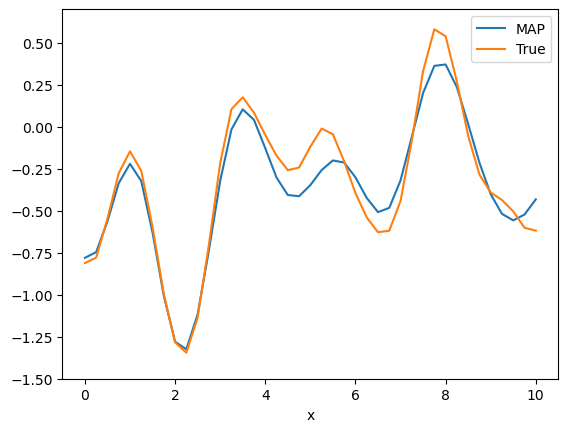

In [21]:
map_x.plot()
dl.plot(x_true.funvals)#.plot('--')
plt.legend(['MAP', 'True'])
plt.ylim(-1.5, 0.7)

In [22]:
map_x

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 FEniCSContinuous(41,)

Parameters:
 True

Array:
CUQIarray([-0.43229091, -0.52261595, -0.55731997, -0.51887896,
           -0.40193751, -0.21426907,  0.01629236,  0.23528147,
            0.37053821,  0.36240094,  0.20037969, -0.06030886,
           -0.31967737, -0.48291133, -0.50847171, -0.42373451,
           -0.30095764, -0.21341244, -0.20061376, -0.2581447 ,
           -0.34746814, -0.41373217, -0.40635267, -0.30256815,
           -0.12798607,  0.04088741,  0.10341288, -0.01617728,
           -0.32295311, -0.73632559, -1.11707065, -1.32464426,
           -1.27976286, -1.00609082, -0.62932368, -0.32337124,
           -0.22057132, -0.33633063, -0.56351663, -0.7464525 ,
           -0.7803307 ])

In [23]:
#posterior_samples = BP.UQ(Ns=3000, Nb=2, percent=97)
posterior = BP.posterior()
#sampler = cuqi.sampler.NUTS(posterior, max_depth=4, x0=np.zeros(G_domain.par_dim)+.001)
#sampler = cuqi.sampler.ULA(posterior, x0=np.zeros(G_domain.par_dim)+.001, scale=0.00000005)
# np.zeros(G_domain.par_dim)+.001

initial_point = np.zeros(G_domain.par_dim) # x_true.to_numpy()
#initial_point = 0.5*map_x.to_numpy()

#sampler = cuqi.experimental.mcmc.PCN(posterior, initial_point=initial_point, scale=0.05)#, max_depth=10, scale=0.005)
sampler_choice = "NUTS"
if sampler_choice == "NUTS":
    sampler = cuqi.experimental.mcmc.NUTS(posterior, initial_point=initial_point, max_depth=5, step_size=1e-3)
    Ns = 400
    Nb = 20 #20
elif sampler_choice == "MALA":
    sampler = cuqi.experimental.mcmc.MALA(posterior, initial_point=initial_point, scale=2.1e-7)
    Ns = 1000
    Nb = 20

elif sampler_choice == "ULA":
    sampler = cuqi.experimental.mcmc.ULA(posterior, initial_point=initial_point, scale=2.1e-7)
    Ns = 100
    Nb = 20


_ = sampler.warmup(Nb)
_ = sampler.sample(Ns)


#posterior_samples = sampler.sample_adapt(100, Nb=10)

Sample: 100%|██████████| 400/400 [14:13<00:00,  2.13s/it, acc rate: 65.00%]


In [24]:
Nb_extra = 80
posterior_samples = sampler.get_samples().burnthin(Nb+Nb_extra)

In [25]:
try:
    print(sampler.scale)
except:
    pass

/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0.00446773]


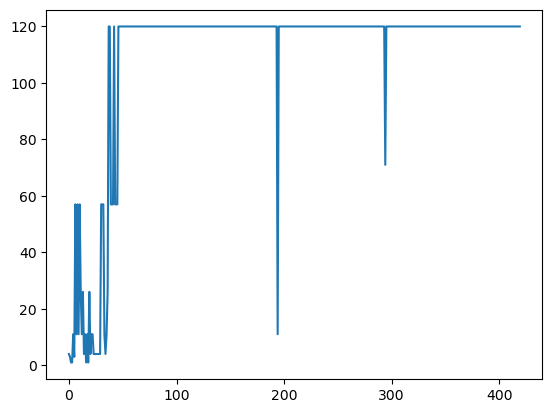

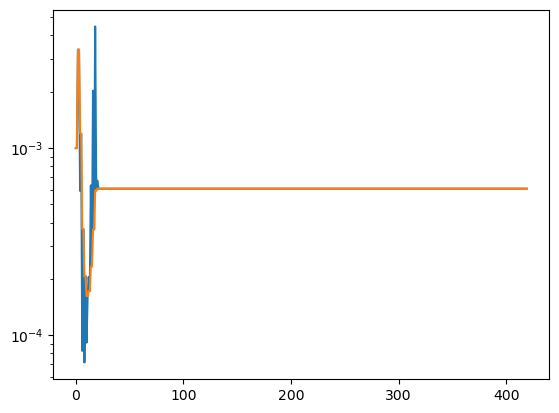

In [26]:
try:
    plt.plot(sampler.num_tree_node_list)
    plt.figure()
    plt.semilogy(sampler.epsilon_list)
    plt.semilogy(sampler.epsilon_bar_list)
    print(np.max(sampler.epsilon_list))
except:
    pass

In [27]:
2**7

128

In [28]:
# sampler.scale

Code cell for generating Figure 1

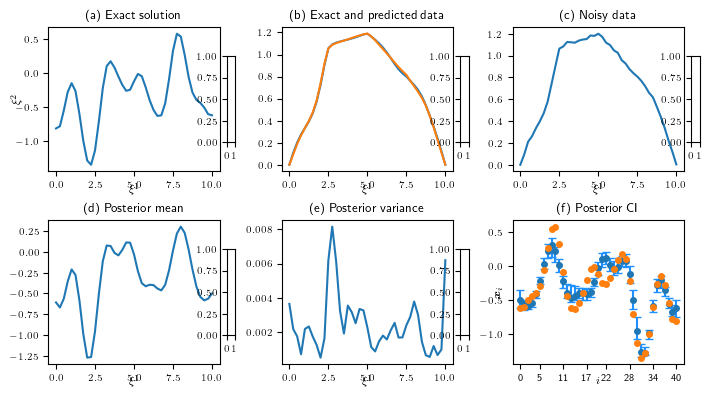

In [29]:


import os
from matplotlib import ticker
import matplotlib.pyplot as plt

# Set up matplotlib
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Use latex package
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

# Data directory
fig_dir = './figs/'

# Figure file
fig_dir = fig_dir 

# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Figure version
version = 'v8'

# Figure file
fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'

# Create the figure
cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3,
                        figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                        layout="constrained")

# Define the colors to be used in the plots
colors = ['C0', 'green', 'purple', 'k', 'gray']

# (a)
plt.sca(axs[0,0])
im = x_true.plot(subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2: 
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.gca().set_ylim(0, 1)

#plt.gca().set_xlim(0, 1)
plt.gca().set_title('(a) Exact solution')
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5

# (b)
plt.sca(axs[0,1])
im = y_true.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])

if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
    plt.gca().set_title('(b) Exact data')
else:
    samples_mean = cuqi.array.CUQIarray(posterior_samples.mean(), geometry=G_domain)
    A(samples_mean).plot(subplots=False)
    plt.gca().set_title('(b) Exact and predicted data')
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5


# (c)
plt.sca(axs[0,2])
im = y_obs.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(c) Noisy data')

# (d)
plt.sca(axs[1,0])
im = posterior_samples.plot_mean(
    subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.gca().set_ylim(0, 1)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5

#plt.gca().set_xlim(0, 1)
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(d) Posterior mean')

# (e)
plt.sca(axs[1,1])
im = posterior_samples.funvals.vector.plot_variance(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])

if physical_dim == 2:
    cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    cb.locator = ticker.MaxNLocator(nbins=4)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(e) Posterior variance')

# (f)
plt.sca(axs[1,2])
lci = posterior_samples.plot_ci(
    97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
lci[0].set_label("Mean")
lci[1].set_label("Exact")
lci[2].set_label("$97\\%$ CI")
#plt.ylim(-5, 3)
plt.legend(ncols=2) 
plt.ylabel(r'$\bm{x}_i$')
plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.set_label_coords( -0.06, 0.5)
plt.xlabel('$i$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(f) Posterior CI')
n_ticks = 8
num_var = posterior_samples.geometry.par_dim
tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
plt.xticks(tick_ids, tick_ids)
# switch legend off
plt.gca().legend().set_visible(False)

# Save the figure
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

In [30]:
posterior_samples.compute_ess()

array([ 1.53122612,  3.08822664,  5.6308138 ,  7.59767857,  6.09998045,
        8.32226088,  9.82082298,  6.82482872,  5.95200129,  6.80129942,
        9.83228297, 11.44084825,  2.61294314,  2.91185035,  1.46885476,
        1.38965336,  1.45496104,  3.63681091,  7.40660241,  8.16223699,
        6.61630527,  1.59216156,  1.34159195,  2.22862113,  1.39430729,
        3.59480082,  2.24955447,  2.37490852,  5.18873683,  5.93897848,
        5.85720444, 18.71718465,  9.1020351 ,  3.56058276,  5.83110148,
        2.15211984, 16.80596388,  7.14485906,  8.33577782,  7.90654456,
        9.75645483])

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'x14'}>,
        <AxesSubplot: title={'center': 'x14'}>],
       [<AxesSubplot: title={'center': 'x15'}>,
        <AxesSubplot: title={'center': 'x15'}>],
       [<AxesSubplot: title={'center': 'x22'}>,
        <AxesSubplot: title={'center': 'x22'}>],
       [<AxesSubplot: title={'center': 'x6'}>,
        <AxesSubplot: title={'center': 'x6'}>],
       [<AxesSubplot: title={'center': 'x8'}>,
        <AxesSubplot: title={'center': 'x8'}>]], dtype=object)

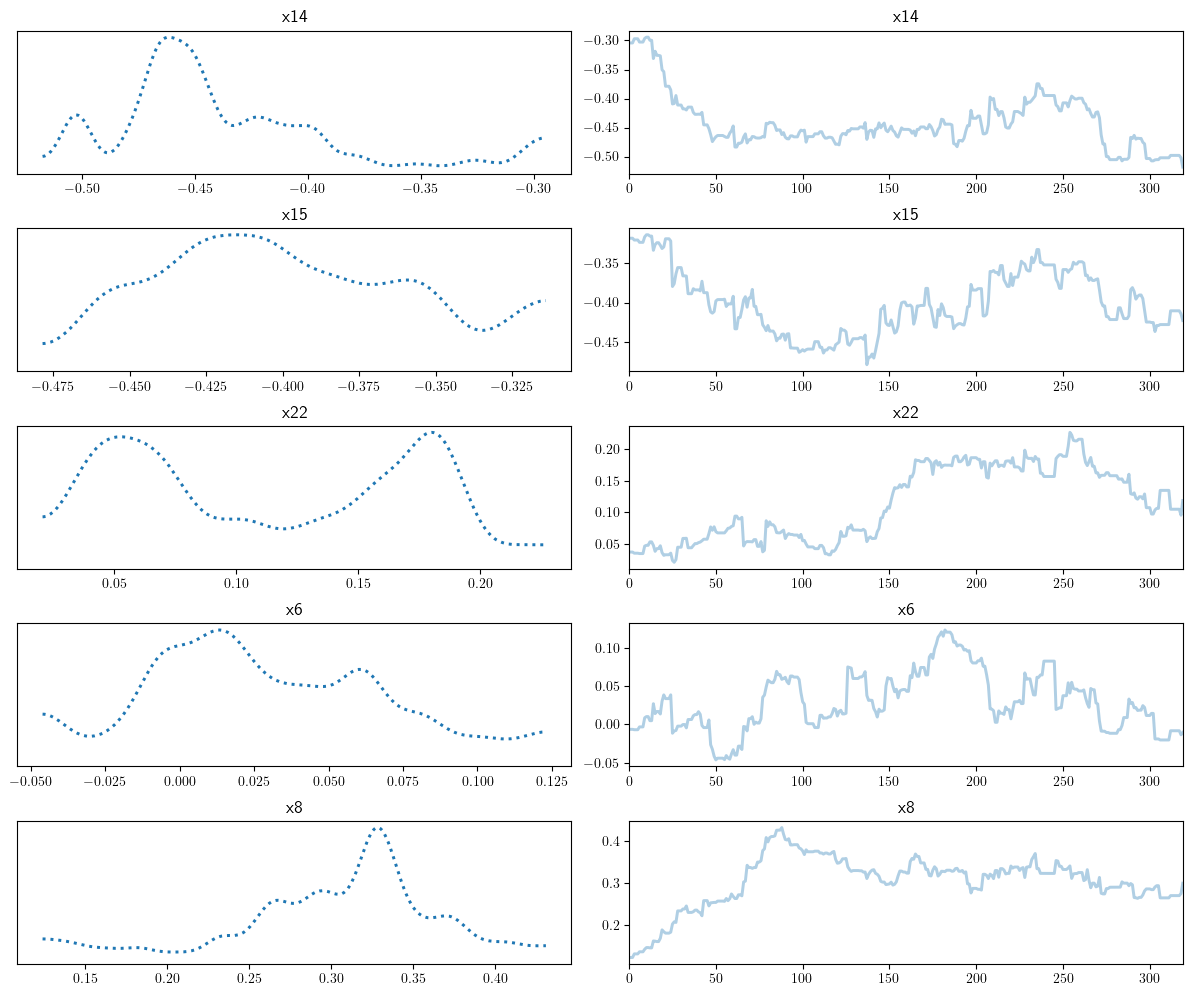

In [31]:
posterior_samples.plot_trace()

Plotting 5 randomly selected samples


[[<matplotlib.lines.Line2D at 0x19afca830>],

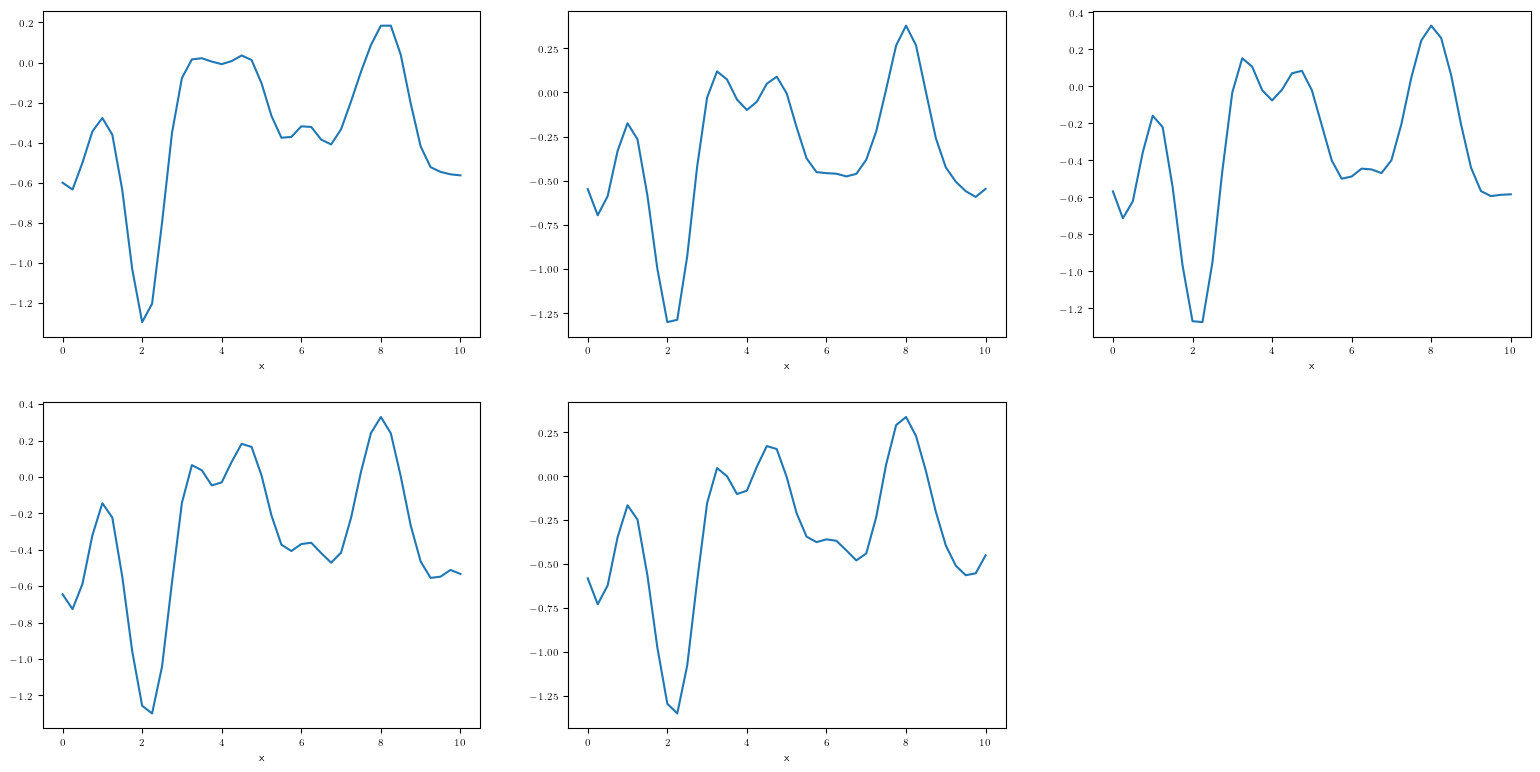

In [32]:
posterior_samples.plot()

In [33]:
# - [x] 1D case 
# - [ ] DG0
# - [ ] TV with non-MY gradient and with NUTS 
# - [x] verify the gradient of the posterior
# - [x] PCN seems to work (for both 1D and 2D cases)
# - [x] Start from x0=the true parameter to debug

## Verify gradient  (model)

0.042412495347431106


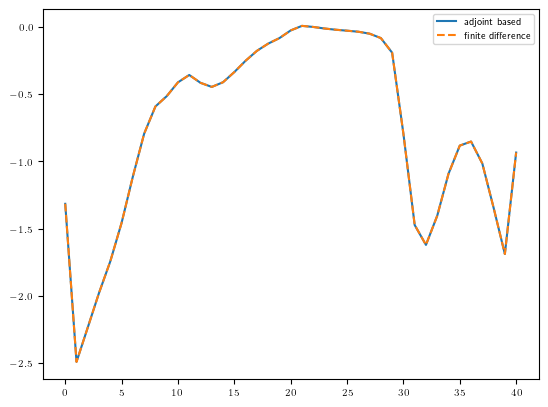

In [34]:
# import check_grad
from scipy.optimize import check_grad
from cuqi.utilities import approx_gradient

np.random.seed(3)
# random direction y
y0 = np.ones(G_range.par_dim) # np.random.randn(G_range.par_dim)
y0[0] = 0
y0[-1] = 0
V = G_range.function_space
# corresponding fenics function
y0_fun = dl.Function(V)
y0_fun.vector()[:] = y0

# objective function
def f(x):
    return A(x).T@ y0.reshape(-1,1)
    #return A(x).vector().get_local().T@ y0.reshape(-1,1)

# objective function gradient
def fprime(x):
    return A.gradient(y0, x)

# random input x (the point which gradient is calculated with respect to)
x0 = np.random.randn(G_domain.par_dim)

# assert that the gradient is correct
print(check_grad(f, fprime, x0))

plt.plot(fprime(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(f, x_true, 1e-6), '--')
plt.legend(['adjoint based', 'finite difference'])


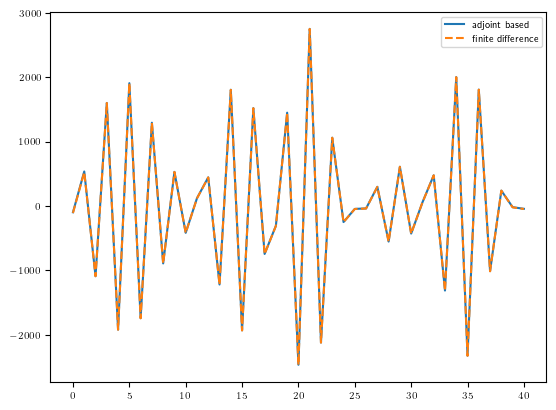

In [35]:
## Verify gradient  (posterior)

plt.plot(posterior.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(posterior.logd, x_true, 1e-6), '--')
plt.legend(['adjoint based', 'finite difference'])